In [160]:
#Author: Connor Hennen

#Let's start adding all the relevant stuff

def getDataSet():
    '''
    Function to just import the data
    
    Param: None. Changes working directory and then imports file as pandas dataframe.
    
    Return: Pandas DataFrame of .csv file
    '''
    import os
    import pandas as pd
    
    os.chdir('/Users/connorvhennen/Desktop/terrorism_project')
    
    terror1 = pd.read_csv('globalterror1.csv',low_memory = False)    
    return terror1

#can search for colnames within total text, split by name, take element[0] of split list, and then find the last 'GLOBAL TERRORISM DATABASE CODEBOOK' and the number before that is your page number
#can also search thru for each page of dictionary
#can also split by column name while reading the PDF

def getDataDictionaryPDF(kagglePage):
    '''
    Function to webscrape the PDF supplied on the Kaggle website, which holds all the variable encodings.
    
    Param: URL to the terrorism dataset on Kaggle
    
    Return: Very long string with all the text from the PDF
    ''' 
    import requests
    import io
    from PyPDF2 import PdfFileReader
    from urllib2 import urlopen
    import re
    kagglePage = urlopen(kagglePage).read()
    kagglePage = str(kagglePage)
    codenums = re.findall(r'(?<=[[]GTD Codebook[]])([[]\d[]])',kagglePage)[0]
    searchStr = '(?<=\'\[\'' + codenums + '\'\][:]).+'
    url = re.findall(r'(?<=\[2\]:).+?(?=\\n)',kagglePage)[0][1:]

    
    totalContents = ''
    r = requests.get(url, stream=True)
    f = io.BytesIO(r.content)
    reader = PdfFileReader(f)
    i = 0
    morepages = True
    pages = {}
    while morepages ==True:
        try:
            contents = ''
            contentLines = reader.getPage(i).extractText().split('\n')
            for line in contentLines:
                contents += line
            #contents = re.sub(r'\\n','',contents)
            contents = str(contents.encode('utf-8'))
            pages[i] = contents
        except:
            print 'There are '+ str(i) + ' pages in the PDF'
            morepages = False
        i+=1
        totalContents += contents  
        totalContents = re.sub('GLOBAL TERRORISM DATABASE CODEBOOK\s+©UNIVERSITY OF MARYLAND\s+JUNE 2017','',totalContents)
    
    totalContents = re.sub(r'\s+',' ',totalContents)
    totalContents = totalContents.split('INTRODUCTION')[2]

    return totalContents

In [161]:
terrorDF = getDataSet()

In [162]:
dataEncodingDict = getDataDictionaryPDF('https://www.kaggle.com/START-UMD/gtd')



def cutoutParanthesisAroundNonKeywords(dataEncodingDict):
    '''
    Function to sub out all the paranthesis around non-keywords. The point is
    so that we can use a findall function that picks up everything
    after a variable name enclosed in parantheses until it reaches
    the next variable, which will be preceded by a '('
    
    Param: The long string that contains everything from the variable encoding PDF.
    
    Return: Same string, except with paranthesis around non-keywords subbed out for dashes.
    ''' 
    import re
    allcols = list(terrorDF)
    for col in allcols[::-1]:
        dataEncodingDict = re.sub(col,'BOzRDER43'+col + 'BOzRDER43',dataEncodingDict)
        
    dataEncodingDict = re.sub(r'[(](?=[^BOzRDER43])','-',dataEncodingDict)
    dataEncodingDict = re.sub(r'(?<=[^BOzRDER43])[)]','-',dataEncodingDict)
    dataEncodingDict = re.sub(r'BOzRDER43','',dataEncodingDict)
    return dataEncodingDict

dataEncodingDict = cutoutParanthesisAroundNonKeywords(dataEncodingDict)
#Note that there are too many irregularities in the PDF for this to be exhaustive.
#Accounting for every single difference in format would not be an efficient use of time
#The goal is just to get a dict whose values contain info about most keyw.

There are 64 pages in the PDF


In [163]:
#This is mostly just to make it easier to understand what the variables are, without nltk, it's not near the amount 
#of work necessary to get variables useful outside of just human comprehension

#Dict that will hold all the relevant encodings/basic information for variables
encodingDict = {}

def delLeadingWhiteSpace(aStr):
    '''
    Function to just delete all the leading whitespace of a string.
    
    Param1: A string
    
    Return: The same string but without any leading whitespace
    ''' 
    whitespace = False
    w = 0
    while aStr[w] == ' ':
        w += 1
    return aStr[w:]
 

def findVariableEncoding(dataEncodingDict,name):
    '''
    Function to assign value--associated text/meaning of a variable-- to key -- variable name
    
    Param1: The long string that contains everything from the variable encoding PDF.
    Param2: The name of the variable of interest.
    
    Return: A dictionary that just hold all the relevant values for a single key
    '''     
    import re
    ransomMentions = re.findall(r'[(]' + str(name) + '[)].+?(?=[(])',dataEncodingDict)[0]    
    ransomDict = {}
    ransomnums = re.findall(r'\d+(?= [=])',ransomMentions)
    ransomnums = ransomnums[::-1]
    for n in ransomnums:
        ransomVal = ransomMentions.split(str(n) + ' =')[1]
        ransomMentions = re.sub(str(n) + ' =' + ransomVal,'',ransomMentions)
        
        ransomDict[n] = delLeadingWhiteSpace(ransomVal)
    return ransomDict

def findVariableEncoding2(dataEncodingDict,encodingDict,terrorDF):
    '''
    Function that implements findVariableEncoding(dataEncodingDict,name) function on all variable names
    
    Param1: The long string that contains everything from the variable encoding PDF.
    Param2: The overarching dictionary that stores the values for all the dictionaries of each individual key
    Param3: The name of the variable of interest.
    
    
    Return: An updated overarching dictionary that stores the values for all the dictionaries of each individual key
    '''     
    import re

    dfNames = list(terrorDF)
    for name in dfNames:
        try:
            if len(findVariableEncoding(dataEncodingDict,name)) > 0:
                encodingDict[name] = findVariableEncoding(dataEncodingDict,name)
        except:
            pass
    return encodingDict


encodingDict = findVariableEncoding2(dataEncodingDict,encodingDict,terrorDF)

def cleanDataSet(terrorDF,dataEncodingDict,encodingDict):
    '''
    Function that just grabs some general data for mostly categorical variables that don't have encodings 
    but rather have unintuivite names. ndays for example will have the value of 
    Days of Kidnapping / Hostage Incident. Such a dictionary will make it easy to lookup and understand what
    variables mean in general. Keep in mind that the encoding PDF is pretty unstandardized and this dict is just
    designed to give the user a quicker way to understand what a variable is referring to but isn't necessarily
    exhaustive or concise.
    
    Param1: The terrorism dataframe
    Param2: The long string that contains everything from the variable encoding PDF.
    Param3: The overarching dictionary that stores the values for all the dictionaries of each individual key
    
    
    Return: An updated overarching dictionary that stores the values for all the dictionaries of 
    each individual key
    '''     
    import re
    dfNames = list(terrorDF)
    splitDataEncoder = dataEncodingDict
    splitDataEncoder = str(splitDataEncoder.split('(' + dfNames[0] + ')')[1])
    
    for name in dfNames:
        if name not in encodingDict:
            try:
                sentList = re.findall(r'(?<=[.]).+?[(]' + str(name) + '[)]',splitDataEncoder)[0].split('.')
                encodingDict[name] = delLeadingWhiteSpace(sentList[len(sentList)-1]) 
            except:
                pass
    
    return encodingDict

encodingDict = cleanDataSet(terrorDF,dataEncodingDict,encodingDict)

In [164]:
#We will use merge sort and list(set(keywordList)) in order to make do away w/ repitions
#and to match equal elements even if they are worded different orders
#Implement merge sort
def merge(left, right):
    res = []
    l = 0
    r = 0
    while l < len(left) and r < len(right):
        if left[l] <= right[r]:
            res.append(left[l])
            l += 1
        else:
            res.append(right[r])
            r += 1
    res += left[l:]
    res += right[r:]
    return res

#Merge Sort
def myMergeSort(aList):
    if len(aList) <= 1:
        return aList
    
    mid = len(aList)//2
    left = aList[:mid]
    right = aList[mid:]

    left = myMergeSort(left)
    right = myMergeSort(right)
    return list(merge(left,right))




def extractKeyWords(df,colname,summ):
    ''' 
    Function that does text extraction for variable's whose elements are described by unstandardized text. Aims to
    capture meaningful words (people, religions, countries, places, etc) without the use of an NLP module, but with 
    only re, urllib and numpy (just for the np.NaN).
    
    Param1: The terror df
    Param2: The name of feature we are trying to extract text from
    Param3: If true, we are looking at the summary feature and have to sub out a few minor things.
    
    
    Return: The same terrorDF but updated with the given column only containing keyword elements. It also
    passes the input dataframe by reference, so it is altered in the same way.
    '''     
    from urllib import urlopen
    import re
    import numpy as np
    summarySample = list(df[colname])
    
    stopWordPage=urlopen('http://www.lextek.com/manuals/onix/stopwords1.html').read()
    stopWordPage = str(stopWordPage)
    stopWordPage = stopWordPage.split('</pre>')[0]
    stopWordPage = stopWordPage.split('#')[len(stopWordPage.split('#'))-1]
    stopWords = stopWordPage.split() + ['specific','sources','people']
      
    for i in range(len(summarySample)):
        if summarySample[i] == summarySample[i]:
            summarySample[i] = str(summarySample[i])
            currSample = summarySample[i].split()
            fixedSample = []
            for j in range(len(currSample)):
                if currSample[j].lower() not in stopWords and currSample[j][0] == currSample[j][0].upper() and len(currSample[j]) > 0:
                    temp = re.sub(r'\.','',currSample[j])
                    temp = re.sub(r'\'s','',temp)
                    temp = re.sub(r'\"','',temp)
                    temp = re.sub(r'\'','',temp)
                    temp = re.sub(r'!','',temp)
                    temp = re.sub(r',','',temp)
                    temp = re.sub(r';','',temp)
                    temp = re.sub(r'[(]','',temp)
                    temp = re.sub(r'[)]','',temp)
                    motiveStr3 = re.sub(r'\.','',temp)
                    motiveStr3 = re.sub(r'  ',' ',motiveStr3)
                    motiveStr3 = re.sub(r'\"','',motiveStr3)
                    motiveStr3 = re.sub(r'\'','',motiveStr3)
                    motiveStr3 = re.sub(r',','',motiveStr3)
                    motiveStr3 = re.sub(r'[(]','',motiveStr3)
                    motiveStr3 = re.sub(r'[)]','',motiveStr3)
                    motiveStr3 = re.sub(r';','',motiveStr3)
                    motiveStr3 = re.sub(r'[)]','',motiveStr3)
                    motiveStr3 = re.sub(r'!','',motiveStr3)
                    motiveStr3 = re.sub(r'”','',motiveStr3)
                    motiveStr3 = re.sub(r'[$]\d+?(?=[^\d])','',motiveStr3)
                    motiveStr3 = re.sub(r'“','',motiveStr3)
                    motiveStr3 = re.sub(r'/',' ',motiveStr3)
                    motiveStr3 = re.sub(r'\\x.+','',motiveStr3)
                    motiveStr3 = re.sub(r'\\','',motiveStr3)
                    temp = re.sub(r'  ',' ',motiveStr3)
                    if summ == True:
                        temp = re.sub(r'\d','',temp)
                        temp = re.sub(r':','',temp)
                        temp = re.sub(r'[$]','',temp)
                    if re.search(r'\w',temp):
                        fixedSample.append(temp)
            
            if len(fixedSample) > 0:
                df.at[i,colname] = myMergeSort(list(set(fixedSample)))
            else:
                df.at[i,colname] = np.NaN
                
    return df

#Added a copy for illustration purposes (as the input df is passed by referenece)
terrorDFcopy = terrorDF.copy()
motiveKeys = extractKeyWords(terrorDFcopy,'motive',False)

In [165]:
summaryKeys = extractKeyWords(terrorDFcopy,'summary',True)

In [166]:
print terrorDF['summary'][5:10]
print summaryKeys['summary'][5:10]

5    1/1/1970: Unknown African American assailants ...
6                                                  NaN
7    1/2/1970: Unknown perpetrators detonated explo...
8    1/2/1970: Karl Armstrong, a member of the New ...
9    1/3/1970: Karl Armstrong, a member of the New ...
Name: summary, dtype: object
5    [African, American, Black, Cairo, Illinois, St...
6                                                  NaN
7    [California, Company, Edes, Electric, Gas, Oak...
8    [Armstrong, Gang, Gym, Karl, Madison, ROTC, Re...
9    [Armstrong, Gang, Headquarters, Karl, Lab, Mad...
Name: summary, dtype: object


In [167]:
targetKeys = extractKeyWords(terrorDFcopy,'target1',False)

In [168]:
target1s = targetKeys['target1']

In [169]:
import re

targetStr = ''
for l in target1s:
    if l == l:
        curr = l
        for innerl in curr:
            innerl = re.sub(r'[[]','',innerl)
            innerl = re.sub(r'[]]','',innerl)
            targetStr += innerl + ' '


In [170]:
motiveKeyWords = list(terrorDF['motive'])
print motiveKeyWords[0:30] #looks like it could be useful but there are just so many nan's to be much more than a
#sorta interesting text extraction exercise

[nan, nan, nan, nan, nan, 'To protest the Cairo Illinois Police Deparment', nan, nan, 'To protest the War in Vietnam and the draft', 'To protest the War in Vietnam and the draft', nan, 'Protest the draft and Vietnam War', nan, nan, 'To protest United States owned businesses in Puerto Rico', nan, nan, 'Suspected motives were to protest the Vietnam War and/or show support for the Black Panther Party and/or show support for the Young Lords.', nan, 'Retaliation for the store owner who shot and killed an African American attempting to commit a robbery at his store.', nan, nan, 'The incident took place during disturbances between the Black Student Union and the university.', 'The incident took place during heightened antiwar sentiments in Seattle Washington.', 'Intimidate the Black Panther Party.', nan, nan, nan, 'The attack occurred during the violent Iowa Beef Packers strike in South Sioux City.', 'The motive of the attack was to prevent the African American community of West Point Mississ

In [171]:
#Let's just get the columns of interest
df = terrorDF
df = df.rename(columns={'gname':'GroupName','iyear':'Year','imonth':'Month','country':'Country','region':'Region','city':'City','crit1':'GoalPoliEconReligion','crit2':'GoalSendMessage','crit3':'GoalNotHumanitarian','success':'Success','attacktype1':'AttackType','targtype1':'TargetType','targsubtype1':'TargetSubType','natlty1':'VictimNationality','weaptype1':'WeaponType','weapsubtype1':'WeaponSubType','weapdetail':'WeaponDetail','nkill':'NumKilled','nwound':'NumWounded','property':'PropertyDmg','propextent':'PropertyDmgExtent','ishostkid':'Kidnapping','ransom':'Ransom','INT_LOG':'InternationalBorder','INT_IDEO':'InternationalOrigins','INT_MISC':'InternationalMisc','related':'RelatedIncidents','summary':'Summary','motive':'Motive'})
tempdict = {'gname':'GroupName','iyear':'Year','imonth':'Month','country':'Country','region':'Region','city':'City','crit1':'GoalPoliEconReligion','crit2':'GoalSendMessage','crit3':'GoalNotHumanitarian','success':'Success','attacktype1':'AttackType','targtype1':'TargetType','targsubtype1':'TargetSubType','natlty1':'VictimNationality','weaptype1':'WeaponType','weapsubtype1':'WeaponSubType','weapdetail':'WeaponDetail','nkill':'NumKilled','nwound':'NumWounded','property':'PropertyDmg','propextent':'PropertyDmgExtent','ishostkid':'Kidnapping','ransom':'Ransom','INT_LOG':'InternationalBorder','INT_IDEO':'InternationalOrigins','INT_MISC':'InternationalMisc','related':'RelatedIncidents','summary':'Summary','motive':'Motive'}
cols = list(tempdict.values())
print cols

['Kidnapping', 'VictimNationality', 'RelatedIncidents', 'Motive', 'InternationalOrigins', 'WeaponDetail', 'GroupName', 'Summary', 'Ransom', 'City', 'TargetSubType', 'NumWounded', 'Month', 'TargetType', 'AttackType', 'WeaponSubType', 'GoalPoliEconReligion', 'GoalNotHumanitarian', 'GoalSendMessage', 'Success', 'InternationalBorder', 'Country', 'Region', 'InternationalMisc', 'Year', 'PropertyDmgExtent', 'WeaponType', 'PropertyDmg', 'NumKilled']


In [172]:
#To make our name data frame in alphabetical order, we will implement myQuickSort algorithm. We may also use
#this for related incidents elements, as they often have the same values, but in different orders

#Implement myQuickSort
def partition(aList,lowerBound,upperBound):#helper function
    piv = lowerBound
    
    for i in range(lowerBound+1,upperBound+1):
        if aList[i] <= aList[lowerBound]:
            piv += 1
            aList[i], aList[piv] = aList[piv], aList[i]
    aList[piv], aList[lowerBound] = aList[lowerBound], aList[piv]
    return piv

#Recursive myQuickSort
def myQuickSort(aList,lowerb,upperb):
    if lowerb < upperb:
        piv = partition(aList,lowerb,upperb)
        myQuickSort(aList,lowerb,piv-1)
        myQuickSort(aList,piv+1,upperb)
    return aList

cols = myQuickSort(cols,0,len(cols)-1)

df = df[[i for i in cols]]

In [173]:
df.shape

(170350, 29)

In [174]:
#Saving chunk, don't need to run everytime
import os
import pandas as pd
    
os.chdir('/Users/connorvhennen/Desktop/terrorism_project')
#df['Motive']

#df1 = terrorDF.rename(columns={'gname':'GroupName','iyear':'Year','imonth':'Month','country':'Country','country_txt':'CountryDef','region':'Region','city':'City','crit1':'GoalPoliEconReligion','crit2':'GoalSendMessage','crit3':'GoalNotHumanitarian','success':'Success','attacktype1':'AttackType','attacktype1_txt':'AttackTypeDef','targtype1':'TargetType','targtype1_txt':'TargetTypeDef','targsubtype1':'TargetSubType','natlty1':'VictimNationality','weaptype1':'WeaponType','weaptype1_txt':'WeaponTypeDef','weapsubtype1':'WeaponSubType','weapdetail':'WeaponDetail','nkill':'NumKilled','nwound':'NumWounded','property':'PropertyDmg','propextent':'PropertyDmgExtent','ishostkid':'Kidnapping','ransom':'Ransom','INT_LOG':'InternationalBorder','INT_IDEO':'InternationalOrigins','INT_MISC':'InternationalMisc','related':'RelatedIncidents','summary':'Summary','motive':'Motive'})
#tempdict = {'gname':'GroupName','iyear':'Year','imonth':'Month','country':'Country','country_txt':'CountryDef','region':'Region','city':'City','crit1':'GoalPoliEconReligion','crit2':'GoalSendMessage','crit3':'GoalNotHumanitarian','success':'Success','attacktype1':'AttackType','attacktype1_txt':'AttackTypeDef','targtype1':'TargetType','targtype1_txt':'TargetTypeDef','targsubtype1':'TargetSubType','natlty1':'VictimNationality','weaptype1':'WeaponType','weaptype1_txt':'WeaponTypeDef','weapsubtype1':'WeaponSubType','weapdetail':'WeaponDetail','nkill':'NumKilled','nwound':'NumWounded','property':'PropertyDmg','propextent':'PropertyDmgExtent','ishostkid':'Kidnapping','ransom':'Ransom','INT_LOG':'InternationalBorder','INT_IDEO':'InternationalOrigins','INT_MISC':'InternationalMisc','related':'RelatedIncidents','summary':'Summary','motive':'Motive'}
#cols = list(tempdict.values())
#df1 = df1[cols]
#df.to_csv('terrorColsFull.csv')
#df1.to_csv('terrorColsTxt.csv')

In [175]:
def importConciseTerrorDF(text):
    '''
    Function to just import a cleanler and more concise dataframe, with more interpretable variable names
    and only the columns we are mainly interested in.
    
    Param: None. Changes working directory and then imports file as pandas dataframe.
    
    Return: Pandas DataFrame of .csv file
    '''
    import os
    import pandas as pd
    
    os.chdir('/Users/connorvhennen/Desktop/terrorism_project')
    if text == False:
        terror1 = pd.read_csv('terrorCols.csv',low_memory = False)    
    else:
        terror1 = pd.read_csv('terrorColsTxt.csv',low_memory = False)  
    return terror1    

newDF = importConciseTerrorDF(False)
newDF['summary'] = summaryKeys['summary']


In [176]:
print newDF.shape

    

(170350, 31)


In [177]:
#Drop unknown groups
newDF = newDF[newDF.GroupName != 'Unknown']
newDF = newDF.drop('Unnamed: 0', 1)
print newDF.shape

(92044, 30)


In [178]:
newDF = newDF.reset_index(drop=True)
colm = list(terrorDF)


In [179]:
#Given 29 features and 170,350 rows, we still have quite a bit of cleaning to do.

def inPlaceSort(df,colname):
    '''
    Function to sort order of related incidents and convert them into lists of ints rather 
    than one long str. Thus, they will be of them same value and point to the same
    terrorist org.
    
    Param1: A terror DF
    Param2: A column that we want to sort, in this case 'RelatedIncidents'
    
    Return: No return value, sorts in place
    '''    
    import re
    for i in range(df.shape[0]):
        if df.at[i,colname] == df.at[i,colname]:
            temp = df.at[i,colname]
            temp = re.sub(r' ','',temp)
            temp = re.sub(r'and',',',temp)
            temp = re.sub(r'\\+?\d','',temp)
            temp = temp.split(',')
            intTemp = [int(x) for x in temp if len(x) > 0]
            df.at[i,colname] = myQuickSort(intTemp,0,len(intTemp)-1)

print newDF['RelatedIncidents'][30:50]
inPlaceSort(newDF,'RelatedIncidents') 
print newDF['RelatedIncidents'][30:50]

30                                         NaN
31                                         NaN
32                                         NaN
33                                         NaN
34                                         NaN
35                                         NaN
36                                         NaN
37                                         NaN
38    197002060004, 197002060005, 197002060006
39    197002060005, 197002060004, 197002060006
40    197002060006, 197002060004, 197002060005
41                                         NaN
42                                         NaN
43    197002080001, 197002080002, 197002090003
44    197002080002, 197002080001, 197002090003
45    197002090003, 197002080001, 197002080002
46                                         NaN
47                                         NaN
48                                         NaN
49                                         NaN
Name: RelatedIncidents, dtype: object
30                    

In [180]:
#looking into motives
import re
allMotives = newDF['Motive']
motiveStr = ''
import numpy as np

motiveListList = []
for motiveList in allMotives:
    
      if motiveList == motiveList:
         a = re.sub('[[]','',''.join(motiveList.split(',')))
         a = re.sub('[]]','',a)
         a = re.sub('\'','',a)
         motiveStr += a + ' '
         a = a.split()
         a = myMergeSort(a)
         motiveListList.append(a)
      else: 
         motiveListList.append([np.nan])
         
motivewordsall = motiveStr.split()
motiveCounter = {j:0 for j in motivewordsall}
for motive in motivewordsall:
    motiveCounter[motive] += 1
motiveCounter

{'Andreas': 1,
 'Pongu': 2,
 'Abbas': 4,
 'jihad': 3,
 'Olympics': 4,
 'Redwoods': 1,
 'Geun-hye': 1,
 'Sukhram': 2,
 'Elaya': 1,
 'Ronald': 5,
 'Western': 27,
 'SPO': 3,
 'Adbul': 1,
 'Masiguil': 1,
 'Nikolic': 1,
 'Myar': 1,
 'Pokhrel': 1,
 'Devrimici': 8,
 'Mahmuda': 1,
 'Shinning': 1,
 'bringing': 1,
 'Reddy': 4,
 'Phalangists': 1,
 'Presumably': 1,
 'Sanda': 2,
 'Madhesi': 7,
 'Madhesh': 3,
 'Sandi': 1,
 'Ahlu': 1,
 'Paul': 18,
 'KFPT': 2,
 'Ansar': 73,
 'Merlin': 1,
 'Janasadharaner': 1,
 'Bailey': 1,
 'hadow': 1,
 'Dissident': 1,
 'Kaczynski': 1,
 'Presidential': 5,
 'Croat': 1,
 'Sioux': 7,
 'Tahrik': 2,
 'Rasanayagam': 1,
 'Tobchi': 1,
 'Falah': 1,
 'Guerrero\\xc2\\xa0': 1,
 'Guerdon': 1,
 'HLS': 1,
 'Hamas': 41,
 'Hamam': 1,
 'Sought': 1,
 'military': 2,
 'Mangel': 1,
 'rebel': 2,
 'Jumpei': 1,
 'Jurado': 1,
 'psychological': 3,
 'Mustapha': 1,
 'Syrians': 3,
 'Casey': 1,
 'Zinjibar': 1,
 'Zaldy': 1,
 'Fornan': 1,
 'occupying': 3,
 'strike': 9,
 'Pilipinas': 2,
 'until': 5,
 

In [181]:
allmotivecounts = newDF['Motive'].value_counts()
allmotivecounts

#We now have a motive feature that might be useful in the future

['Unknown']                                                                                                                                             6008
['ISIL', 'Iraq', 'Islamic', 'Levant']                                                                                                                    234
['Maoists']                                                                                                                                              186
['Army', 'NPA', 'People']                                                                                                                                172
['Taliban']                                                                                                                                              170
['Iraq', 'Shiite', 'Sunni']                                                                                                                              164
['2015', '6', 'Bangladesh', 'January']                    

In [182]:
newDF['Motive'][1:20]

1                                                   NaN
2          ['Cairo', 'Deparment', 'Illinois', 'Police']
3                                                   NaN
4                                    ['Vietnam', 'War']
5                                    ['Vietnam', 'War']
6                                                   NaN
7                         ['Protest', 'Vietnam', 'War']
8                                                   NaN
9                          ['Puerto', 'Rico', 'United']
10                                                  NaN
11                                                  NaN
12    ['Black', 'Lords', 'Panther', 'Party', 'Suspec...
13                                                  NaN
14               ['African', 'American', 'Retaliation']
15                                                  NaN
16                                                  NaN
17                        ['Black', 'Student', 'Union']
18                            ['Seattle', 'Washi

In [183]:
import numpy as np
newDF['Motive'][7]

"['Protest', 'Vietnam', 'War']"

In [184]:
#Turn the elements into list type, not a numpy array string or whatever this -"['Protest', 'Vietnam', 'War']"- is
newDF['MotivesAsList'] = newDF['Motive'].copy()

for i in range(newDF.shape[0]):
    newDF.at[i,'MotivesAsList'] = motiveListList[i]
motiveLists = newDF['MotivesAsList']
#newDF['Motive'][7]
newDF['MotivesAsList'][7]

['Protest', 'Vietnam', 'War']

In [185]:
#implement mode function
def myModeFinder(aList):
    temp =[]
    for j in range(len(aList)):
        temp.append(aList.count(aList[j]))
    maxTemp = max(temp)
    mostFreqentList = [i for i in aList if aList.count(i) == maxTemp]
    modeList = list(set([val for val in mostFreqentList]))
    return modeList

print myModeFinder([1,2,2,2,2,7,7,5,5,5,5])

#implement median function
def myMedianFinder(aList):
    aList = myQuickSort(aList,0,len(aList)-1)
    halfLen = len(aList)//2
    if len(aList) % 2 == 0:
        aList[halfLen]
    else:
        return (aList[halfLen - 1] + aList[halfLen])/2.0
    


print myMedianFinder([1,2,2,2,2,7,7,5,5,5,5])

[2, 5]
3.5


In [ ]:
#Have spent ages trying to extract text from the motives features that would accurately describe similar occurences.
'''
import category_encoders as ce #category_encoders is 
le =  ce.OneHotEncoder(return_df=False,verbose = True,impute_missing=False,handle_unknown="ignore")

newDF = importConciseTerrorDF()
newDF = newDF[newDF.GroupName != 'Unknown']
newDF = newDF.drop('Unnamed: 0', 1)
newDF = newDF.reset_index(drop=True)
inPlaceSort(newDF,'RelatedIncidents')   
X = np.array(newDF['Motive'])
Y = le.fit_transform(X)
'''
from sklearn import preprocessing

lb = preprocessing.MultiLabelBinarizer()
Y = lb.fit_transform(motiveListList)

newDF['MotiveEncodings'] = ['i' for i in range(newDF.shape[0])]
for i in range(len(Y)):
    newDF.at[i,'MotiveEncodings'] = Y[i]

In [220]:
print 'At this point I have created a sparse density matrix that could be useful for a bag of words model. ' \
+ 'Although interesting, this was actually extremely time-consuming and at the end of the day, beyond the scope ' \
+ 'of things at this time, so Im going to have to let this pursuit go for the time being'
print newDF['MotiveEncodings'][3:8]
print newDF['Motive'][3:8]
print '\nElements 4, 5, and 7 are obviously related, and that fact is described in the binary matrix, but Im ' \
+ 'not sure where to go with this right now, aside from a bag of words classifier which isnt really within the ' \
+ 'scope of things'

At this point I have created a sparse density matrix that could be useful for a bag of words model. Although interesting, this was actually extremely time-consuming and at the end of the day, beyond the scope of things at this time, so Im going to have to let this pursuit go for the time being
3    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
5    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
6    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
7    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: MotiveEncodings, dtype: object
3                              NaN
4               ['Vietnam', 'War']
5               ['Vietnam', 'War']
6                              NaN
7    ['Protest', 'Vietnam', 'War']
Name: Motive, dtype: object

Elements 4, 5, and 7 are obviously related, and that fact is described in the binary matrix, but Im not sure where to go with this right now, aside from a bag of words classifier which isnt

In [187]:
print 'We see that elements 5 and 7 do have a high cosine simularity here. But again, beyond scope- letting go of '\
+ 'for now'
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
allMotives = motiveLists
def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]
            
print cosine_sim(' '.join(allMotives[5]), ' '.join(allMotives[7]))

We see that elements 5 and 7 do have a high cosine simularity here. But again, beyond scope- letting go of for now
0.709297266606


We can however create a wordcloud of motives.


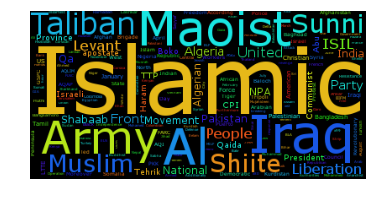

In [188]:
print 'We can however create a wordcloud of motives.'

from os import path
from scipy.misc import imread
import matplotlib.pyplot as plt
import random
from wordcloud import WordCloud

#We don't wan't to count unknwn as a motive..
motiveStr1 = re.sub('Unknown ','',motiveStr)

wordcloud = WordCloud(font_path='/Library/Fonts/Verdana.ttf',
                      relative_scaling = 0.3,
                      random_state=61495,
                      ).generate(motiveStr1)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

We can also do a word cloud for summaries


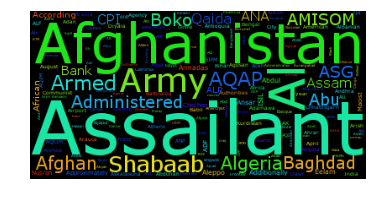

In [189]:
print 'We can also do a word cloud for summaries'

allSummaries = newDF['summary']
summaryStr = ''
import numpy as np

for summaryL in allSummaries:
    
      if summaryL == summaryL:
         summaryL = re.sub(',','',summaryL[0])
         a = re.sub('[[]','',''.join(summaryL))
         a = re.sub('[]]','',a)
         a = re.sub('\'','',a)
         summaryStr += a + ' '

wordcloud1 = WordCloud(font_path='/Library/Fonts/Verdana.ttf',
                      relative_scaling = .3,
                      max_words = 200,
                      random_state=61495,
                      ).generate(summaryStr)
plt.imshow(wordcloud1)
plt.axis("off")
plt.show()

Finally, a word cloud for the targets, which is the most telling of all.


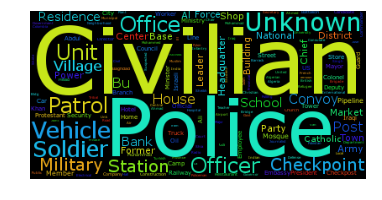

In [190]:
print 'Finally, a word cloud for the targets, which is the most telling of all.'

wordcloud2 = WordCloud(font_path='/Library/Fonts/Verdana.ttf',
                      relative_scaling = .3,
                      max_words = 200,
                      random_state=61495,
                      ).generate(targetStr)
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()


In [191]:
#Let's start off simple, letting AttackType, City, Country, 'GoalNotHumanitarian', 'GoalPoliEconReligion', 
#'GoalSendMessage','WeaponType','TargetType', and 'Year' be our independant variables and 'GroupName' be our 
#dependant.



#We need to do a few things to preprocess the data. We must deal with misssing values, we must one-hot-encode the 'object'
#variables, in this case just 'City' and 'Groupname' to start, and finally we must scale our features.

#First let's create a DataFrame with just the variables we are currently interested in.
df = newDF
def selectColumns(df,varsOfInterest):
    df2 = df.copy()
    dfcolnames = list(df2)
    indices = myQuickSort([dfcolnames.index(c) for c in varsOfInterest],0,len([dfcolnames.index(c) for c in varsOfInterest])-1)
    df2 = df2[[dfcolnames[i] for i in indices]]#just modifies the dataframe in place, no return value
    return df2

ourVars = ['AttackType', 'City', 'Country', 'GoalNotHumanitarian', 'GoalPoliEconReligion', 'GoalSendMessage','WeaponType','TargetType', 'Year','GroupName']

df2 = selectColumns(newDF,ourVars)
df2

,AttackType,City,Country,GoalNotHumanitarian,GoalPoliEconReligion,GoalSendMessage,GroupName,TargetType,WeaponType,Year
0,1,Santo Domingo,58,1,1,1,MANO-D,14,13,1970
1,6,Mexico city,130,1,1,1,23rd of September Communist League,7,13,1970
2,2,Cairo,217,1,1,1,Black Nationalists,3,5,1970
3,1,Montevideo,218,1,1,1,Tupamaros (Uruguay),3,5,1970
4,7,Madison,217,1,1,1,New Year's Gang,4,8,1970
5,7,Madison,217,1,1,1,New Year's Gang,2,8,1970
6,3,Baraboo,217,0,1,1,"Weather Underground, Weathermen",4,6,1970
7,7,Denver,217,1,1,1,Left-Wing Militants,4,8,1970
8,7,Detroit,217,1,1,1,Left-Wing Militants,2,8,1970
9,7,Rio Piedras,217,1,1,1,Armed Commandos of Liberation,1,8,1970


In [192]:
#Let's see how many unique groups there are and how frequently they attack

df2['GroupName'].value_counts()

Taliban                                               6575
Shining Path (SL)                                     4551
Islamic State of Iraq and the Levant (ISIL)           4287
Farabundo Marti National Liberation Front (FMLN)      3351
Al-Shabaab                                            2683
Irish Republican Army (IRA)                           2669
Revolutionary Armed Forces of Colombia (FARC)         2481
New People's Army (NPA)                               2414
Kurdistan Workers' Party (PKK)                        2152
Boko Haram                                            2077
Basque Fatherland and Freedom (ETA)                   2024
Communist Party of India - Maoist (CPI-Maoist)        1766
Liberation Tigers of Tamil Eelam (LTTE)               1606
National Liberation Army of Colombia (ELN)            1483
Maoists                                               1424
Tehrik-i-Taliban Pakistan (TTP)                       1252
Palestinians                                          11

In [193]:
print 'There are 3453 unique groups. Many of them appear to have only attacked once so we cant do a classifier regardless.' +'Lets build our classifier for a limited number of groups\n'

uniquegroups = df2['GroupName'].value_counts()

#How many groups were repsonsible for 90% of all total attacks? 
totalAttacks90 = df2.shape[0]*.9
i = 1
cumulTotal = 0
while cumulTotal < totalAttacks90:
    cumulTotal = sum(list(uniquegroups[0:i]))
    i += 1
print str(i) + ' groups were responsible for 90% of all attacks from known groups\n'

uniquegroups[0:i]

There are 3453 unique groups. Many of them appear to have only attacked once so we cant do a classifier regardless.Lets build our classifier for a limited number of groups

350 groups were responsible for 90% of all attacks from known groups



Taliban                                                  6575
Shining Path (SL)                                        4551
Islamic State of Iraq and the Levant (ISIL)              4287
Farabundo Marti National Liberation Front (FMLN)         3351
Al-Shabaab                                               2683
Irish Republican Army (IRA)                              2669
Revolutionary Armed Forces of Colombia (FARC)            2481
New People's Army (NPA)                                  2414
Kurdistan Workers' Party (PKK)                           2152
Boko Haram                                               2077
Basque Fatherland and Freedom (ETA)                      2024
Communist Party of India - Maoist (CPI-Maoist)           1766
Liberation Tigers of Tamil Eelam (LTTE)                  1606
National Liberation Army of Colombia (ELN)               1483
Maoists                                                  1424
Tehrik-i-Taliban Pakistan (TTP)                          1252
Palestin

In [194]:
#Let's see what happens when we drop
#all the rows that aren't part of the groups responsible for 90% of the attacks 

percAllGroups90 = uniquegroups.index[0:349].tolist()
#Lets drop all rows that aren't from a top 90% group
badIndices = []
for i in range(df2.shape[0]):
    if df2.at[i,'GroupName'] not in percAllGroups90:
        badIndices.append(i)
df90 = df2.copy()
df90 = df90.drop(badIndices)
df90 = df90.reset_index(drop=True)
df90.shape

(82849, 10)

In [195]:
#350 is still quite a lot of values to One-Hot-Encode, let's just do the top 10 groups

totalfromtop10 = 0

for i in range(10):
   totalfromtop10 += uniquegroups[i]
   
(totalfromtop10*1.0)/df2.shape[0]

# In[49]:
#Just the top 10 groups are responsible for 36.11% of the killings
#Let's try to just do these ones
top10Groups = uniquegroups.index[0:10].tolist()
#Lets drop all rows that aren't from a top 90% group
badIndices = []
for i in range(df2.shape[0]):
    if df2.at[i,'GroupName'] not in top10Groups:
        badIndices.append(i)

df10 = df2.copy()
df10 = df10.drop(badIndices)
df10 = df10.reset_index(drop=True)
print df10.shape
df10[0:20]

(33240, 10)


,AttackType,City,Country,GoalNotHumanitarian,GoalPoliEconReligion,GoalSendMessage,GroupName,TargetType,WeaponType,Year
0,9,Bamban,160,0,1,1,New People's Army (NPA),4,13,1970
1,9,Mabalacat City,160,0,1,1,New People's Army (NPA),4,13,1970
2,2,Londonderry,603,1,1,1,Irish Republican Army (IRA),17,8,1970
3,2,Londonderry,603,1,1,1,Irish Republican Army (IRA),14,5,1970
4,2,Belfast,603,1,1,1,Irish Republican Army (IRA),14,5,1970
5,2,Belfast,603,1,1,1,Irish Republican Army (IRA),14,5,1970
6,3,Crossmaglen,603,1,1,1,Irish Republican Army (IRA),3,6,1970
7,3,Belfast,603,1,1,1,Irish Republican Army (IRA),17,6,1970
8,2,Belfast,603,1,1,1,Irish Republican Army (IRA),14,5,1970
9,1,Belfast,603,1,1,1,Irish Republican Army (IRA),14,5,1971


In [196]:
#Preprocess, feature engineer, and create two seperate matrices for all the predictors, 
#and the target variable, respectively.

#Modify the Year feature to refer to a particular decade, so now it will be categorical
df10['Decade'] = ['Decade'] * df10.shape[0]

#Create and fill lists with a symmetric relationship (decadeKeys[index n]:decadeValues[index n])
#between the dates the corresponding decade. Keys are the dates, values are the decades
decadeValues = []
decadeKeys = []
decadeValues.append(['dec7']*10)
decadeValues.append(['dec8']*10)
decadeValues.append(['dec9']*10)
decadeValues.append(['dec0']*10)
decadeValues.append(['dec1']*10)
decadeKeys.append([1970 + i for i in range(10)])
decadeKeys.append([1980 + i for i in range(10)])
decadeKeys.append([1990 + i for i in range(10)])
decadeKeys.append([2000 + i for i in range(10)])
decadeKeys.append([2010+ i for i in range(10)])

#Use the created lists to create a dictionary using dictionary comprehension and the zip() function
decadeDict = {i:j for k in range(5) for i,j in zip(decadeKeys[k],decadeValues[k])}

#Set the element of the decade column to the decade that is the value to the Year column element,
#according to the above dict
for j in range(df10.shape[0]):
    df10.at[j,'Decade'] = decadeDict[df10.at[j,'Year']]
    
#Change order of columns, so dependant is last, and remove 'Year', the categotical independants
    #are all lined up as one straight sequence, with the 'goal' features being pushed back,
    #while each section retains alphabeic order within it's section
colnames = list(df10)
del colnames[9]
temp = colnames[9]
colnames[9] = colnames[6]
colnames[6] = temp
colnames = myQuickSort(colnames[:-1],0,len(colnames[:-1])-1) +  [colnames[9]] 

#Switch column positions to make all the features of the same type (needs to be OneHotEncoded vs doesn't need to be)
    #remain alphabetically in order but are seperated
temp = colnames[4]
colnames[4] = colnames[6]
colnames[6] = temp

temp = colnames[4]
colnames[4] = colnames[7]
colnames[7] = temp

temp = colnames[5]
colnames[5] = colnames[8]
colnames[8] = temp

temp = colnames[7]
colnames[7] = colnames[8]
colnames[8] = temp

df10 = df10[colnames]

colnames = list(df10)

#City column has way too many unique values, so for the sake of speed in our model we can delete it
del colnames[1]
df10 = df10[colnames]
colnames = list(df10)

# Importing the dataset
X = df10.iloc[:, :-1].values
y = df10.iloc[:, 8].values

# Taking care of missing data
#from sklearn.preprocessing import Imputer

#First check for missing data
missingSpots = []
missingIndices = []

for i in range(df10.shape[0]):
    for j in range(len(colnames)):
        if df10.at[i,colnames[j]] != df10.at[i,colnames[j]]:
            missingSpots.append([i,colnames[j]])
            missingIndices.append(i)
'''
#Only the cities column has missing values, so... 
    #Instead of: imputer = Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis = 0), <- (or similar) 
    #Let's do:
cities = list(df10['City'])
theMode = myModeFinder(cities)
for i in missingIndices:
    df10.at[i,'City'] = theMode[0]
'''                      
    

def getEncodedMatrices():
    X = df10.iloc[:, :-1].values
    #y = df10.iloc[:, 9].values ----- ends at 8 now that we deleted City feature
    y = df10.iloc[:, 8].values

    #Encode categorical variables
    from sklearn.preprocessing import LabelEncoder, OneHotEncoder
    
    labelencoder_X = LabelEncoder()
    #Because all the features' numbers refer to 
    #types, they are actually categorical, except the Goal feautures (which are already one-hot 
    #encoded), only the string features need the label econdoder step though
    
    X[:, 2] = labelencoder_X.fit_transform(X[:, 2]) 
    
    onehotencoder = OneHotEncoder(categorical_features = [0,1,2,3,4])#Don't one hot encode the goal columns as they already are
    X = onehotencoder.fit_transform(X).toarray()
    
    # Encoding the Dependent Variable
    labelencoder_y = LabelEncoder()
    y = labelencoder_y.fit_transform(y)
    
    return X,y

X,y = getEncodedMatrices()

In [197]:
print type(X)
print X[:3]
print type(df10)
print df10[:3]

<type 'numpy.ndarray'>
[[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   1.  0.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   1.  0.  1.  1.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  

In [198]:
print [i for i in df10['GroupName'][:25]]
print y[:25]

["New People's Army (NPA)", "New People's Army (NPA)", 'Irish Republican Army (IRA)', 'Irish Republican Army (IRA)', 'Irish Republican Army (IRA)', 'Irish Republican Army (IRA)', 'Irish Republican Army (IRA)', 'Irish Republican Army (IRA)', 'Irish Republican Army (IRA)', 'Irish Republican Army (IRA)', 'Irish Republican Army (IRA)', 'Irish Republican Army (IRA)', 'Irish Republican Army (IRA)', 'Irish Republican Army (IRA)', "New People's Army (NPA)", 'Irish Republican Army (IRA)', 'Irish Republican Army (IRA)', 'Irish Republican Army (IRA)', 'Irish Republican Army (IRA)', 'Irish Republican Army (IRA)', 'Irish Republican Army (IRA)', 'Irish Republican Army (IRA)', 'Irish Republican Army (IRA)', 'Irish Republican Army (IRA)', 'Irish Republican Army (IRA)']
[6 6 3 3 3 3 3 3 3 3 3 3 3 3 6 3 3 3 3 3 3 3 3 3 3]


In [199]:
#Get a list that has one index corresponding to each unique terror group
groupIndices = []
for g in top10Groups:
    groupIndices.append(list(df10.iloc[:, 8].values).index(g))
    
#GroupLabelDict will store the groups as values and their encoded labels as keys
groupLabelDict = {y[i]:df10.iloc[:, 8].values[i] for i in groupIndices}
print groupLabelDict

{0: 'Al-Shabaab', 1: 'Boko Haram', 2: 'Farabundo Marti National Liberation Front (FMLN)', 3: 'Irish Republican Army (IRA)', 4: 'Islamic State of Iraq and the Levant (ISIL)', 5: "Kurdistan Workers' Party (PKK)", 6: "New People's Army (NPA)", 7: 'Revolutionary Armed Forces of Colombia (FARC)', 8: 'Shining Path (SL)', 9: 'Taliban'}


In [200]:
#Most models don't require feature scaling so we'll leave this as a comment for now
'''
from sklearn.preprocessing import StandardScaler
stdScaleX = StandardScaler()
xTrain = stdScaleX.fit_transform(xTrain)
xTest = stdScaleX.transform(xTest)
'''

'\nfrom sklearn.preprocessing import StandardScaler\nstdScaleX = StandardScaler()\nxTrain = stdScaleX.fit_transform(xTrain)\nxTest = stdScaleX.transform(xTest)\n'

In [201]:
print groupLabelDict
print top10Groups

{0: 'Al-Shabaab', 1: 'Boko Haram', 2: 'Farabundo Marti National Liberation Front (FMLN)', 3: 'Irish Republican Army (IRA)', 4: 'Islamic State of Iraq and the Levant (ISIL)', 5: "Kurdistan Workers' Party (PKK)", 6: "New People's Army (NPA)", 7: 'Revolutionary Armed Forces of Colombia (FARC)', 8: 'Shining Path (SL)', 9: 'Taliban'}
['Taliban', 'Shining Path (SL)', 'Islamic State of Iraq and the Levant (ISIL)', 'Farabundo Marti National Liberation Front (FMLN)', 'Al-Shabaab', 'Irish Republican Army (IRA)', 'Revolutionary Armed Forces of Colombia (FARC)', "New People's Army (NPA)", "Kurdistan Workers' Party (PKK)", 'Boko Haram']


In [202]:
#Logistic model implementation:

# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split


xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2, random_state = 61495)


In [203]:
fakeX = df10.iloc[:, :-1]
fakeY = df10.iloc[:, 8]
xTrain1, xTest1, yTrain1, yTest1 = train_test_split(fakeX, fakeY, test_size = 0.2, random_state = 61495)

trainingIndices = xTrain1.index
testingIndices = xTest1.index



In [204]:
#Feature scaling
from sklearn.preprocessing import StandardScaler
stdScaler= StandardScaler()
xTrain = stdScaler.fit_transform(xTrain)
xTest = stdScaler.transform(xTest)

#Fitting logistic regression model to training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 61495)
classifier.fit(xTrain, yTrain)

#Predicting test set results
yPred = classifier.predict(xTest)
yPredLog = classifier.predict(xTest)
yTestLog = yTest

#Making confusion matrix
from sklearn.metrics import confusion_matrix
confusionMatLogistic = confusion_matrix(yTest, yPred)

#Computing accuracy score
from sklearn.metrics import accuracy_score
accScoreLogistic = accuracy_score(yPred,yTest)

print 'Logistic regression accuracy score is ' + str(round(accScoreLogistic,4)*100) + '%.\n'
print 'Our model appears to do very well, with hardly any classifications for almost every terror group.\n'
print 'The most errors (11) come from misclassifying the ' + groupLabelDict[5] + ' as\n' + groupLabelDict[4] + ', presumably because the Kurdistan Workers\' Party and ISIL have had \nsignificant country and decade overlap.\n'
print 'Confusion matrix:'
print confusionMatLogistic

Logistic regression accuracy score is 99.7%.

Our model appears to do very well, with hardly any classifications for almost every terror group.

The most errors (11) come from misclassifying the Kurdistan Workers' Party (PKK) as
Islamic State of Iraq and the Levant (ISIL), presumably because the Kurdistan Workers' Party and ISIL have had 
significant country and decade overlap.

Confusion matrix:
[[ 538    0    0    0    0    0    0    0    0    0]
 [   0  409    0    0    0    0    0    0    0    0]
 [   0    0  708    0    0    0    0    0    0    0]
 [   0    0    0  518    0    0    0    0    0    0]
 [   1    0    0    0  835   11    1    0    0    1]
 [   0    0    0    2    2  406    0    0    0    0]
 [   0    0    0    0    0    0  475    0    0    0]
 [   0    0    0    0    0    0    0  537    0    0]
 [   0    0    0    0    0    0    0    2  887    0]
 [   0    0    0    0    0    0    0    0    0 1315]]


In [205]:
#Now, with a KNN model:

# Splitting the dataset into the Training set and Test set
from sklearn.cross_validation import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2, random_state = 61495)

from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix
stdScale = StandardScaler()
xTrain = stdScale.fit_transform(xTrain)
xTest = stdScale.transform(xTest)

# Fitting K-NN to the Training set
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, p = 2)
classifier.fit(xTrain, yTrain)

#Test set predictions
yPred = classifier.predict(xTest)

#Confusion Matrix
confusionMatKNN = confusion_matrix(yTest, yPred)

#Accuracy score
from sklearn.metrics import accuracy_score
accScoreKNN = accuracy_score(yPred,yTest)

print '\nAccuracy score is ' + str(round(accScoreKNN,4)*100) + '%.\n'
print 'Confustion matrix:'
print confusionMatKNN


Accuracy score is 98.27%.

Confustion matrix:
[[ 536    0    1    0    0    0    0    0    0    1]
 [   3  400    0    0    2    1    0    0    0    3]
 [   1    0  702    0    0    0    0    0    3    2]
 [   2    0    0  507    0    2    1    0    5    1]
 [   1    0    0    2  823   11    1    0    1   10]
 [   0    0    0    0    9  391    0    1    4    5]
 [   0    0    0    2    1    0  465    0    3    4]
 [   1    0    0    0    0    0    3  522    3    8]
 [   2    0    2    1    0    0    0    3  880    1]
 [   2    1    0    0    2    0    1    1    1 1307]]


In [206]:
print '\nOur logistic model actually seems to be more accurate with the current parameters. Let\'s try tinkering with the KNN parameters.\n'


Our logistic model actually seems to be more accurate with the current parameters. Let's try tinkering with the KNN parameters.



In [207]:
#Let's try to find the most accurate combination of parameters for n_neighbors and p, between 1 and 4 and 1 and 3, respectively.

bestAccScore = 0
#the best params end up being 1 and 1. Don't actually run this code unless you want to wait about 5 minutes (:
for n in range(1,5):
    for pVal in range(1,3):
        classifier = KNeighborsClassifier(n_neighbors = n, p = pVal)
        classifier.fit(xTrain, yTrain)

        #Test set predictions
        yPred = classifier.predict(xTest)
        currAccScore = accuracy_score(yPred,yTest)
        
        if currAccScore > bestAccScore:
            bestN = n
            bestP = pVal
            bestAccScore = currAccScore

classifier = KNeighborsClassifier(n_neighbors = 1, p = 1)
classifier.fit(xTrain, yTrain)
#Test set predictions
yPred = classifier.predict(xTest)
bestAccScore = accuracy_score(yPred,yTest)

In [208]:
print 'For KKN models, our best accuracy (without going through an too exhaustive of a tuning search) has an accu' \
'racy of \n' + str(round(bestAccScore,4)*100) + '%. Though slightly improved, the logistic model remains more' \
+ ' accurate.'

For KKN models, our best accuracy (without going through an too exhaustive of a tuning search) has an accuracy of 
98.99%. Though slightly improved, the logistic model remains more accurate.


In [209]:
#To conclude the machine learning exercises, let's put our models into dataframes
#that aren't encoded so we can have a more intuitive/interpretable look at the data
#alongside the predictions

freshDF = importConciseTerrorDF(True)
#Drop unknown groups
freshDF = freshDF[freshDF.GroupName != 'Unknown']
freshDF = freshDF.drop('Unnamed: 0', 1)
freshDF = freshDF.reset_index(drop=True)
freshDF = freshDF.drop(badIndices)
freshDF = freshDF.reset_index(drop=True)
colsToShow = list(df10)
colsToShow[2] = 'Year'
colsToShow[1] = 'CountryDef'
colsToShow[0] = 'AttackTypeDef'
colsToShow[3] = 'TargetTypeDef'
colsToShow[4] = 'WeaponTypeDef'
freshDF = freshDF[colsToShow]

truegroups = list(yTestLog)
for g in range(len(truegroups)):
    truegroups[g] = groupLabelDict[truegroups[g]]
    
predgroups = list(yPredLog)
for p in range(len(predgroups)):
    predgroups[p] = groupLabelDict[predgroups[p]]  

d = {'TrueGroups': [j for j in truegroups], 'PredictedGroups': [y for y in predgroups]}
groups = [('True',[truegroups]),('Pred',[predgroups])]
dfSideBySide = pd.DataFrame(data=d)

dfSideBySide = pd.DataFrame(truegroups, columns=['True Group'])
dfSideBySide['Prediction'] = predgroups



In [210]:
freshDF2 = freshDF.copy()
freshDF2 = freshDF2.loc[[i for i in testingIndices], :]

freshDF2 = freshDF2.reset_index(drop=True)
freshDF2['Prediction'] = predgroups

freshDF2 = freshDF2.rename(columns={'AttackTypeDef':'AttackType','CountryDef':'Country','Year':'Year','TargetTypeDef':'TargetType','WeaponTypeDef':'WeaponType','GoalNotHumanitarian':'OutsideOfHumanLaw','GoalPoliEconReligion':'PoliticalEconomicOrReligiousMotivated','GoalSendMessage':'GoalSendMessage','GroupName':'TrueTerrorGroup','Prediction':'PredictedTerrorGroup'})
freshDF2names = list(freshDF2)
temp = freshDF2names[0]
freshDF2names[0] = freshDF2names[8]
freshDF2names[8] = temp

temp = freshDF2names[1]
freshDF2names[1] = freshDF2names[9]
freshDF2names[9] = temp

myQuickSort(freshDF2names,2,len(freshDF2names)-1)

freshDF2 = freshDF2[freshDF2names]
freshDF2

,TrueTerrorGroup,PredictedTerrorGroup,AttackType,Country,GoalSendMessage,OutsideOfHumanLaw,PoliticalEconomicOrReligiousMotivated,TargetType,WeaponType,Year
0,Taliban,Taliban,Unknown,Afghanistan,1,1,1,Police,Unknown,2016
1,Farabundo Marti National Liberation Front (FMLN),Farabundo Marti National Liberation Front (FMLN),Facility/Infrastructure Attack,El Salvador,1,1,1,Business,Sabotage Equipment,1984
2,Irish Republican Army (IRA),Irish Republican Army (IRA),Assassination,United Kingdom,1,0,1,Military,Firearms,1972
3,Islamic State of Iraq and the Levant (ISIL),Islamic State of Iraq and the Levant (ISIL),Bombing/Explosion,Iraq,1,1,1,Private Citizens & Property,Explosives/Bombs/Dynamite,2014
4,Shining Path (SL),Shining Path (SL),Assassination,Peru,1,1,1,Private Citizens & Property,Firearms,1984
5,Farabundo Marti National Liberation Front (FMLN),Farabundo Marti National Liberation Front (FMLN),Bombing/Explosion,El Salvador,1,1,1,Utilities,Explosives/Bombs/Dynamite,1990
6,Farabundo Marti National Liberation Front (FMLN),Farabundo Marti National Liberation Front (FMLN),Bombing/Explosion,El Salvador,1,1,1,Government (General),Explosives/Bombs/Dynamite,1989
7,Farabundo Marti National Liberation Front (FMLN),Farabundo Marti National Liberation Front (FMLN),Bombing/Explosion,El Salvador,1,1,1,Utilities,Explosives/Bombs/Dynamite,1987
8,Shining Path (SL),Shining Path (SL),Bombing/Explosion,Peru,1,1,1,Transportation,Explosives/Bombs/Dynamite,1983
9,New People's Army (NPA),New People's Army (NPA),Bombing/Explosion,Philippines,1,0,1,Military,Explosives/Bombs/Dynamite,2016


In [211]:
#Let's look at all the rows that have wrong predictions

badIndices = []
for i in range(freshDF2.shape[0]):
    if freshDF2.at[i,'TrueTerrorGroup'] == freshDF2.at[i,'PredictedTerrorGroup']:
        badIndices.append(i)
missedPredDF = freshDF2.copy()
missedPredDF = missedPredDF.drop(badIndices)
#df90 = df90.reset_index(drop=True)
print missedPredDF['Country'].value_counts()
print '\nIt looks like the vast majority of incorrect predictions were due to the fact that both ISIL and the Kurdistan Workers\' Party (PKK) as Islamic State of Iraq and the Levant (ISIL) operate in Turkey.'

Turkey         12
Colombia        2
Indonesia       1
Iraq            1
Philippines     1
Denmark         1
Somalia         1
Netherlands     1
Name: Country, dtype: int64

It looks like the vast majority of incorrect predictions were due to the fact that both ISIL and the Kurdistan Workers' Party (PKK) as Islamic State of Iraq and the Levant (ISIL) operate in Turkey.


In [212]:
badIndices = []
for i in range(terrorDF.shape[0]):
    if terrorDF.at[i,'latitude'] != terrorDF.at[i,'latitude']:
        badIndices.append(i)

terrorDF2 = terrorDF.drop(badIndices)
terrorDF2.shape

(165744, 135)

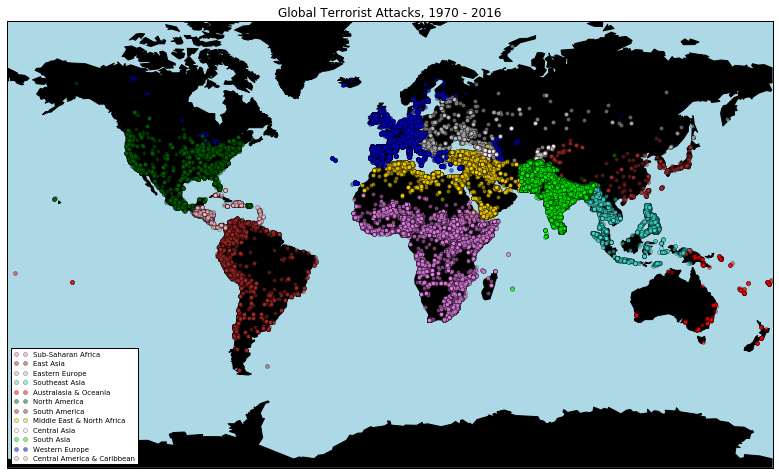

In [213]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.colors

def getRGB(col):
    rbgfinder = matplotlib.colors.ColorConverter()
    return rbgfinder.to_rgb(col)


regions = list(set(terrorDF2.region_txt))

#I used the getRGB function to play with the colors and arrive at these long decimals.
colors = [(.9,.5,.9), (0.6470588235294118, 0.16470588235294117, 0.16470588235294117), (0.7529411764705882, 0.7529411764705882, 0.7529411764705882), (0.25098039215686274, 0.8784313725490196, 0.8156862745098039), (1,0,0), (0.0, 0.39215686274509803, 0.0), 'brown',(1.0, 0.8431372549019608, 0.0), (1.0, 0.9411764705882353, 0.9607843137254902), (0,1,0), (0,0,.85), (1.0, 0.7137254901960784, 0.7568627450980392)]
terrorDF2 = terrorDF
plt.figure(figsize=(15,8))

coldWorld = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=80, llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
coldWorld.drawcountries()
coldWorld.drawcoastlines()
coldWorld.fillcontinents(color='black',lake_color='darkblue', zorder = 1)
coldWorld.drawmapboundary(fill_color='lightblue')

def plotAttacks(clr, rgn):
    xCoord, yCoord = coldWorld([i for i in terrorDF2.longitude[terrorDF2.region_txt == rgn]]
,[j for j in terrorDF2.latitude[terrorDF2.region_txt == rgn]]
)
    coldWorld.plot(xCoord, yCoord, "o", color = clr, label = rgn, markersize =4, alpha = .5)
 
for c, rgn in enumerate(regions):
    plotAttacks(colors[c],rgn)  
    
plt.legend(loc ='lower left', prop= {'size':7})
plt.title("Global Terrorist Attacks, 1970 - 2016")
plt.show()  



['eventid',
 'iyear',
 'imonth',
 'iday',
 'approxdate',
 'extended',
 'resolution',
 'country',
 'country_txt',
 'region',
 'region_txt',
 'provstate',
 'city',
 'latitude',
 'longitude',
 'specificity',
 'vicinity',
 'location',
 'summary',
 'crit1',
 'crit2',
 'crit3',
 'doubtterr',
 'alternative',
 'alternative_txt',
 'multiple',
 'success',
 'suicide',
 'attacktype1',
 'attacktype1_txt',
 'attacktype2',
 'attacktype2_txt',
 'attacktype3',
 'attacktype3_txt',
 'targtype1',
 'targtype1_txt',
 'targsubtype1',
 'targsubtype1_txt',
 'corp1',
 'target1',
 'natlty1',
 'natlty1_txt',
 'targtype2',
 'targtype2_txt',
 'targsubtype2',
 'targsubtype2_txt',
 'corp2',
 'target2',
 'natlty2',
 'natlty2_txt',
 'targtype3',
 'targtype3_txt',
 'targsubtype3',
 'targsubtype3_txt',
 'corp3',
 'target3',
 'natlty3',
 'natlty3_txt',
 'gname',
 'gsubname',
 'gname2',
 'gsubname2',
 'gname3',
 'gsubname3',
 'motive',
 'guncertain1',
 'guncertain2',
 'guncertain3',
 'individual',
 'nperps',
 'nperpcap',
 